In [184]:
import pandas as pd
import numpy as np

# Different possible regression models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.dummy import DummyRegressor

# Other process packages
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
# import statsmodels

# Model scoring and assessment packages
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
import shap

# Model optimization packages
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats

# Visualization packages
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import plotly.graph_objects as go

ImportError: Numba needs NumPy 2.1 or less. Got NumPy 2.2.

Helper functions

In [104]:
def plot_permutation_importance(clf,
                                X,
                                y,
                                scoring,
                                random_state,
                                ax):
    '''
    
    '''
    result = permutation_importance(clf,
        X,
        y,
        scoring=scoring,
        n_repeats=10,
        random_state=random_state,
        n_jobs=-1)
    perm_sorted_idx = result.importances_mean.argsort()

    ax.boxplot(result.importances[perm_sorted_idx].T,
        vert=False,
        labels=X.columns[perm_sorted_idx])
    ax.set_title("Permutation Importances (test set)")
    ax.set_xlabel(scoring)

    fig.tight_layout()
    plt.show()

    return ax

def display_feature_importance(clf,
                               X_train,
                               X_test,
                               y_train,
                               y_test):
    '''
    
    '''

    results = pd.Series(
        clf.feature_importances_,
        index=clf.feature_names_in_,
        ).sort_values(ascending=False)
    print("Feature Importance Ranking:\n", results.index)
    results.plot.bar(figsize=(15, 5))
    r = permutation_importance(clf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
    for i in r.importances_mean.argsort()[::-1]:
        if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
            print(f"{clf.feature_names_in_[i]:<8}"
                f"{r.importances_mean[i]:.3f}"
                f" +/- {r.importances_std[i]:.3f}")
    mdi_importances = pd.Series(clf.feature_importances_, index=X_train.columns)
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 8))
    mdi_importances.sort_values().plot.barh(ax=ax1)
    ax1.set_xlabel("Gini Importance")
    plot_permutation_importance(clf, X_train, y_train, "neg_mean_absolute_error", 42, ax2)
    ax2.set_xlabel("Decrease in neg_mean_absolute_error")
    # fig.subtitle(
    #     "Impurity-based Feature Importance vs Permutation Importances /n on multicolinear features (train set)")
    _ = fig.tight_layout()
    
    fig, ax = plt.subplots(figsize=(12, 8))
    plot_permutation_importance(clf, X_test, y_test, "neg_mean_absolute_error", 42, ax)
    ax.set_title("Permutation Importances (test set)")
    ax.set_xlabel("Decrease in neg_mean_absolute_error")
    _ = ax.figure.tight_layout()
    plt.show()

Read in the main dataset and drop unnecessary columns.

In [3]:
df = pd.read_csv('final_merge.csv',
    index_col=0)
print(f'Dataframe shape: {df.shape}')
print(f'dataframe columns: {df.columns}')

# Drop columns with percentages
df = df[df.columns.drop(list(df.filter(regex='Percent')))]


Dataframe shape: (1730, 54)
dataframe columns: Index(['disasterNumber', 'declarationTitle', 'state', 'Date_x',
       'fipsStateCode', 'fipsCountyCode', 'year', 'county', 'validReg_own',
       'DamageBetween1and1000', 'DamageBetween10001and2000',
       'DamageBetween20001and3000', 'DamageGreaterThan3000', 'validReg_rent',
       'ModerateDamage_rent', 'MajorDamage_rent', 'SubstDamage_rent',
       'fipsCode', 'LATITUDE_county', 'LONGITUDE_county',
       'Geographic Area Name',
       'Estimate!!HOUSING OCCUPANCY!!Total housing units',
       'Percent!!HOUSING OCCUPANCY!!Total housing units',
       'Estimate!!HOUSING OCCUPANCY!!Total housing units!!Occupied housing units',
       'Percent!!HOUSING OCCUPANCY!!Total housing units!!Occupied housing units',
       'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2020 or later',
       'Percent!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2020 or later',
       'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2

Review the dataframe.

In [4]:
df.head()

,disasterNumber,declarationTitle,state,Date_x,fipsStateCode,fipsCountyCode,year,county,validReg_own,DamageBetween1and1000,...,Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1939 or earlier,Name,Date_y,Latitude,Longitude,Max Wind,Max Pressure,Landfall_Lat,Landfall_Lon,dist_from_landfall
0,4798,HURRICANE BERYL,TX,2024-07-05 00:00:00+00:00,48,15,2024,Austin (County),582.0,100.0,...,1147,BERYL,20240708,28.6N,96.0W,80,978,28.6,-96.0,87.175749
1,4798,HURRICANE BERYL,TX,2024-07-05 00:00:00+00:00,48,37,2024,Bowie (County),495.0,36.0,...,1384,BERYL,20240708,28.6N,96.0W,80,978,28.6,-96.0,349.863220
2,4798,HURRICANE BERYL,TX,2024-07-05 00:00:00+00:00,48,39,2024,Brazoria (County),44176.0,5499.0,...,1766,BERYL,20240708,28.6N,96.0W,80,978,28.6,-96.0,63.975663
3,4798,HURRICANE BERYL,TX,2024-07-05 00:00:00+00:00,48,71,2024,Chambers (County),3431.0,417.0,...,333,BERYL,20240708,28.6N,96.0W,80,978,28.6,-96.0,111.469171
4,4798,HURRICANE BERYL,TX,2024-07-05 00:00:00+00:00,48,157,2024,Fort Bend (County),79137.0,4907.0,...,2457,BERYL,20240708,28.6N,96.0W,80,978,28.6,-96.0,72.859249


In [5]:
df.describe()

,disasterNumber,fipsStateCode,fipsCountyCode,year,validReg_own,DamageBetween1and1000,DamageBetween10001and2000,DamageBetween20001and3000,DamageGreaterThan3000,validReg_rent,...,Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1960 to 1969,Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1950 to 1959,Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1940 to 1949,Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1939 or earlier,Date_y,Max Wind,Max Pressure,Landfall_Lat,Landfall_Lon,dist_from_landfall
count,1730.000000,1730.000000,1730.000000,1730.000000,1713.000000,1713.000000,1713.000000,1713.000000,1713.000000,1689.000000,...,1730.000000,1730.000000,1730.000000,1730.000000,1.730000e+03,1730.000000,1730.000000,1730.000000,1730.000000,1730.000000
mean,3094.516763,31.530636,108.391908,2012.023699,6090.835960,1841.802685,155.615295,53.805604,66.267951,4555.212552,...,7281.291908,4995.699422,2400.882081,2139.339306,2.012114e+07,97.234104,953.211561,28.673815,-82.800289,236.829505
std,1458.354903,20.591525,119.229293,7.755594,17289.765569,5212.056569,784.883876,372.534664,511.160118,19365.789881,...,16648.966254,12298.887890,6137.119990,5229.259202,7.756742e+04,19.661540,17.364006,4.368017,7.763506,250.074421
min,1479.000000,1.000000,1.000000,2003.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,39.000000,41.000000,-71.000000,-61.000000,2.003072e+07,65.000000,919.000000,18.000000,-97.200000,4.543943
25%,1554.000000,12.000000,43.000000,2004.000000,324.000000,138.000000,2.000000,0.000000,0.000000,106.000000,...,1129.750000,709.250000,357.250000,371.000000,2.004092e+07,80.000000,939.000000,27.200000,-87.900000,81.909737
50%,4019.000000,28.000000,83.000000,2011.000000,1359.000000,464.000000,15.000000,2.000000,2.000000,581.000000,...,2273.000000,1424.500000,768.000000,790.500000,2.011083e+07,95.000000,952.000000,29.300000,-82.200000,152.902961
75%,4400.000000,48.000000,123.000000,2018.000000,4862.000000,1434.000000,73.000000,13.000000,13.000000,2471.000000,...,5992.000000,3657.750000,1880.500000,1896.250000,2.018101e+07,110.000000,965.000000,30.200000,-79.500000,270.123505
max,4834.000000,72.000000,840.000000,2024.000000,331674.000000,99520.000000,23576.000000,11003.000000,11077.000000,374677.000000,...,240198.000000,145008.000000,99878.000000,63843.000000,2.024101e+07,140.000000,986.000000,34.900000,-65.900000,1312.120049


Merge this dataset with storm information about the closest pass for each observation.

In [6]:
# Rename one column to make merging easier.
df['declarationTitle'].rename('Name')

# Remove HURRICANE from all hurricane names for merging purposes.
df['Name'] = df['Name'].str.replace('HURRICANE ', '')
df.columns

Index(['disasterNumber', 'declarationTitle', 'state', 'Date_x',
       'fipsStateCode', 'fipsCountyCode', 'year', 'county', 'validReg_own',
       'DamageBetween1and1000', 'DamageBetween10001and2000',
       'DamageBetween20001and3000', 'DamageGreaterThan3000', 'validReg_rent',
       'ModerateDamage_rent', 'MajorDamage_rent', 'SubstDamage_rent',
       'fipsCode', 'LATITUDE_county', 'LONGITUDE_county',
       'Geographic Area Name',
       'Estimate!!HOUSING OCCUPANCY!!Total housing units',
       'Estimate!!HOUSING OCCUPANCY!!Total housing units!!Occupied housing units',
       'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2020 or later',
       'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2010 to 2019',
       'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2000 to 2009',
       'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1990 to 1999',
       'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1980 to 1989',
       'E

In [7]:
# Load the data to be merged and rename columns to be more specific.
df_closest_pass = pd.read_csv('closest_pass.csv')
df_closest_pass.rename(columns={'Max Wind':'Closest_Max_Wind', 
                                'Max Pressure':'Closest_Max_Pressure'}, inplace=True)
df_closest_pass.head()


,Name,year,Closest_Max_Wind,Closest_Max_Pressure,fipsCode,distance_from_storm,category
0,BERYL,2024,70,978,48015,40.192025,TS
1,BERYL,2024,25,1004,48037,6.349638,TD
2,BERYL,2024,70,978,48039,37.310013,TS
3,BERYL,2024,50,988,48071,79.163470,TS
4,BERYL,2024,70,978,48157,29.248125,TS


In [8]:
# Merge the original dataframe with the closest pass storm information for each observation.
df = pd.merge(left=df, right=df_closest_pass, on=['Name', 'year', 'fipsCode'])
df.head()

,disasterNumber,declarationTitle,state,Date_x,fipsStateCode,fipsCountyCode,year,county,validReg_own,DamageBetween1and1000,...,Longitude,Max Wind,Max Pressure,Landfall_Lat,Landfall_Lon,dist_from_landfall,Closest_Max_Wind,Closest_Max_Pressure,distance_from_storm,category
0,4798,HURRICANE BERYL,TX,2024-07-05 00:00:00+00:00,48,15,2024,Austin (County),582.0,100.0,...,96.0W,80,978,28.6,-96.0,87.175749,70,978,40.192025,TS
1,4798,HURRICANE BERYL,TX,2024-07-05 00:00:00+00:00,48,37,2024,Bowie (County),495.0,36.0,...,96.0W,80,978,28.6,-96.0,349.863220,25,1004,6.349638,TD
2,4798,HURRICANE BERYL,TX,2024-07-05 00:00:00+00:00,48,39,2024,Brazoria (County),44176.0,5499.0,...,96.0W,80,978,28.6,-96.0,63.975663,70,978,37.310013,TS
3,4798,HURRICANE BERYL,TX,2024-07-05 00:00:00+00:00,48,71,2024,Chambers (County),3431.0,417.0,...,96.0W,80,978,28.6,-96.0,111.469171,50,988,79.163470,TS
4,4798,HURRICANE BERYL,TX,2024-07-05 00:00:00+00:00,48,157,2024,Fort Bend (County),79137.0,4907.0,...,96.0W,80,978,28.6,-96.0,72.859249,70,978,29.248125,TS


Perform a similar process to add county-level cluster information to our main dataframe by merging on fipsCode

In [9]:
df_clusters = pd.read_csv('clusters.csv',
    index_col=0)
df_clusters.head()


,fipsCode,housing_cluster,econ_cluster
0,48015,0,3
1,48015,0,3
2,48015,0,3
3,48037,0,0
4,48039,2,3


In [10]:
# Merge the original dataframe with the closest pass storm information for each observation.
df = pd.merge(left=df, right=df_clusters, on=['fipsCode'])
df.head()

,disasterNumber,declarationTitle,state,Date_x,fipsStateCode,fipsCountyCode,year,county,validReg_own,DamageBetween1and1000,...,Max Pressure,Landfall_Lat,Landfall_Lon,dist_from_landfall,Closest_Max_Wind,Closest_Max_Pressure,distance_from_storm,category,housing_cluster,econ_cluster
0,4798,HURRICANE BERYL,TX,2024-07-05 00:00:00+00:00,48,15,2024,Austin (County),582.0,100.0,...,978,28.6,-96.0,87.175749,70,978,40.192025,TS,0,3
1,4798,HURRICANE BERYL,TX,2024-07-05 00:00:00+00:00,48,15,2024,Austin (County),582.0,100.0,...,978,28.6,-96.0,87.175749,70,978,40.192025,TS,0,3
2,4798,HURRICANE BERYL,TX,2024-07-05 00:00:00+00:00,48,15,2024,Austin (County),582.0,100.0,...,978,28.6,-96.0,87.175749,70,978,40.192025,TS,0,3
3,4798,HURRICANE BERYL,TX,2024-07-05 00:00:00+00:00,48,37,2024,Bowie (County),495.0,36.0,...,978,28.6,-96.0,349.863220,25,1004,6.349638,TD,0,0
4,4798,HURRICANE BERYL,TX,2024-07-05 00:00:00+00:00,48,39,2024,Brazoria (County),44176.0,5499.0,...,978,28.6,-96.0,63.975663,70,978,37.310013,TS,2,3


In [11]:
# Create dependent variable as sum of "damage" columns (replacing Nan values with 0)
df['Damage'] = df['DamageBetween20001and3000'].fillna(0) + df['DamageGreaterThan3000'].fillna(0) + df['MajorDamage_rent'].fillna(0)
df['lnDamage'] = np.log(df['Damage']
                        + 1)  # Use natural log of 'Damage' + 1 given disproportionate number of small values (including 0)

# # Delete original "damage" columns
# df = df.drop(df.columns[0:3], axis=1)

# # Move dependent variable to first column position
# col = df.pop('lnDamage')
# df.insert(0, 'lnDamage', col)
# col = df.pop('Damage')
# df.insert(0, 'Damage', col)

df = df[
    ['Damage',
    'lnDamage',
    'disasterNumber',
    'Estimate!!HOUSING OCCUPANCY!!Total housing units',
    'Estimate!!HOUSING OCCUPANCY!!Total housing units!!Occupied housing units',
    'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2020 or later',
    'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2010 to 2019',
    'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2000 to 2009',
    'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1990 to 1999',
    'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1980 to 1989',
    'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1970 to 1979',
    'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1960 to 1969',
    'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1950 to 1959',
    'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1940 to 1949',
    'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1939 or earlier',
    'Max Wind',
    'Max Pressure',
    'dist_from_landfall',
    'Closest_Max_Wind',
    'Closest_Max_Pressure',
    'distance_from_storm',
    'category',
    'housing_cluster',
    'econ_cluster'
    ]
]

print(f'Count NaN values: {df.isna().any()}') # Damage column has Nan values initially


df.describe()

Count NaN values: Damage                                                                        False
lnDamage                                                                      False
disasterNumber                                                                False
Estimate!!HOUSING OCCUPANCY!!Total housing units                              False
Estimate!!HOUSING OCCUPANCY!!Total housing units!!Occupied housing units      False
Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2020 or later      False
Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2010 to 2019       False
Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2000 to 2009       False
Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1990 to 1999       False
Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1980 to 1989       False
Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1970 to 1979       False
Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built

,Damage,lnDamage,disasterNumber,Estimate!!HOUSING OCCUPANCY!!Total housing units,Estimate!!HOUSING OCCUPANCY!!Total housing units!!Occupied housing units,Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2020 or later,Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2010 to 2019,Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2000 to 2009,Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1990 to 1999,Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1980 to 1989,...,Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1940 to 1949,Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1939 or earlier,Max Wind,Max Pressure,dist_from_landfall,Closest_Max_Wind,Closest_Max_Pressure,distance_from_storm,housing_cluster,econ_cluster
count,6490.000000,6490.000000,6490.000000,6.490000e+03,6.490000e+03,6490.000000,6490.000000,6490.000000,6490.000000,6490.000000,...,6490.000000,6490.000000,6490.000000,6490.000000,6490.000000,6490.000000,6490.000000,6490.000000,6490.000000,6490.000000
mean,217.862866,2.773742,3162.337134,9.283414e+04,7.732702e+04,760.271032,5004.448690,13959.396456,15115.751772,17597.240832,...,3085.143297,2834.794607,97.893683,953.111864,213.838593,77.330508,963.746687,84.519530,0.525116,1.568413
std,1109.160894,2.113212,1455.091984,1.523208e+05,1.312451e+05,2761.810610,15987.581984,25419.435274,23087.235992,29116.638077,...,6607.013828,6484.402472,19.071556,16.439416,232.551337,25.264897,19.480127,105.667171,0.864926,1.405476
min,0.000000,0.000000,1479.000000,2.334000e+03,1.386000e+03,0.000000,0.000000,49.000000,138.000000,154.000000,...,-71.000000,-61.000000,65.000000,919.000000,4.543943,20.000000,919.000000,3.563970,0.000000,0.000000
25%,2.000000,1.098612,1561.000000,1.240325e+04,9.616000e+03,0.000000,0.000000,1350.000000,2043.000000,2214.500000,...,431.000000,417.000000,80.000000,941.000000,76.763811,60.000000,948.000000,34.895796,0.000000,0.000000
50%,12.000000,2.564949,4080.000000,3.068500e+04,2.609700e+04,0.000000,91.000000,3916.000000,5057.000000,5088.000000,...,1003.000000,1036.000000,100.000000,952.000000,140.783924,75.000000,967.000000,56.599276,0.000000,2.000000
75%,62.000000,4.143135,4570.000000,1.108120e+05,8.999700e+04,14.000000,1960.000000,16667.000000,18365.000000,20531.000000,...,2482.000000,2315.000000,110.000000,960.000000,238.176520,100.000000,978.000000,98.131680,1.000000,3.000000
max,21555.000000,9.978409,4834.000000,1.942862e+06,1.789470e+06,48370.000000,343520.000000,341119.000000,222934.000000,297831.000000,...,99878.000000,63843.000000,140.000000,986.000000,1312.120049,140.000000,1007.000000,1000.000000,4.000000,4.000000


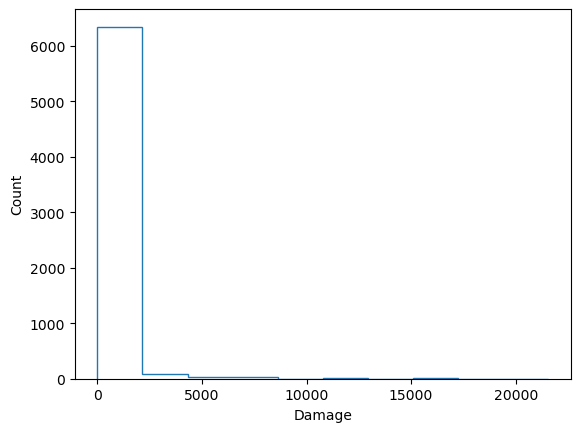

In [12]:
# Plot the dependent variable, 'Damage'

counts, bins = np.histogram(df['Damage'])
plt.stairs(counts, bins)
plt.xlabel('Damage')
plt.ylabel('Count')
plt.show()

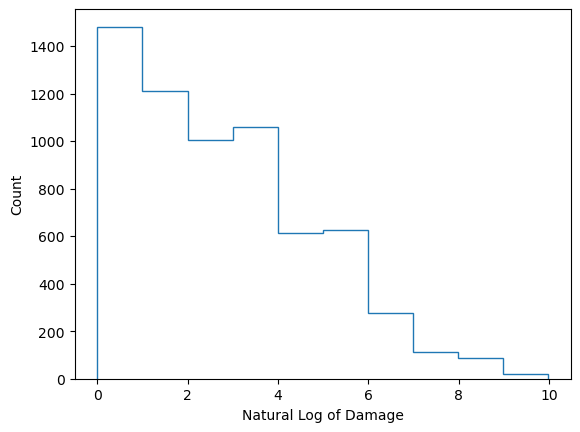

In [13]:
# Plot the dependent variable, 'Damage'

counts, bins = np.histogram(df['lnDamage'])
plt.stairs(counts, bins)
plt.xlabel('Natural Log of Damage')
plt.ylabel('Count')
plt.show()

Engineer a few additional features by combining some of the existing features.

In [14]:
# Factor distance from landfall into the maximum storm windspeed for counties further away from the strongest part of the storm
df['wind_speed_div_distance'] = df['Max Wind'] / df['dist_from_landfall']

Identify the quantitative and categorical features.

In [15]:
categories = [
    'category',
    'housing_cluster',
    'econ_cluster'
]
print(categories)

quants = [x for x in df.columns.tolist() if x not in categories]
quants.remove('Damage')
quants.remove('lnDamage')
quants.remove('disasterNumber')

quants

['category', 'housing_cluster', 'econ_cluster']


['Estimate!!HOUSING OCCUPANCY!!Total housing units',
 'Estimate!!HOUSING OCCUPANCY!!Total housing units!!Occupied housing units',
 'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2020 or later',
 'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2010 to 2019',
 'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2000 to 2009',
 'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1990 to 1999',
 'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1980 to 1989',
 'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1970 to 1979',
 'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1960 to 1969',
 'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1950 to 1959',
 'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1940 to 1949',
 'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1939 or earlier',
 'Max Wind',
 'Max Pressure',
 'dist_from_landfall',
 'Closest_Max_Wind',
 'Closest_Max_Pressure',
 'dista

In [151]:
# Split the dataset into features and target subsets
X = df.drop(['Damage','lnDamage'], axis=1)
y_ = df['lnDamage'] # Use natural log of 'Damage' + 1 given disproportionate number of small values (including 0)
y = df['Damage']

In [152]:
preprocessor = ColumnTransformer(
    transformers=[
        ('quant', Normalizer(), quants),
        ('cat', OneHotEncoder(sparse_output=False).set_output(transform='pandas'), categories)
    ]
).set_output(transform='pandas')
pipe = Pipeline(steps=
                [('preprocessor', preprocessor),
                ])



In [153]:
lr_clf = LinearRegression(n_jobs = -1)
br_clf = BayesianRidge()
rf_clf = RandomForestRegressor(random_state=0,
                               n_jobs = -1)
SVR_clf = SVR(kernel='rbf')
gbr_clf = GradientBoostingRegressor(random_state=0)
hgbr_clf = HistGradientBoostingRegressor(random_state=0)
bgr_clf = BaggingRegressor(random_state=0,
                           n_jobs = -1)
mlpr_clf = MLPRegressor(max_iter=500,
                        random_state=0)
dummy_clf = DummyRegressor()
clf_list = [lr_clf,
            br_clf,
            rf_clf,
            SVR_clf,
            gbr_clf,
            hgbr_clf,
            bgr_clf,
            mlpr_clf,
            dummy_clf,
            ]

X_ = X.drop(['disasterNumber'], axis=1)
X__ = pipe.fit_transform(X_)
scoring = {
    'r2': 'r2',
    'MAE': 'neg_mean_absolute_error',
    'RMSE': 'neg_root_mean_squared_error',
}
for clf in clf_list:
    cross_val_results = cross_validate(clf, X__, y, cv=10, scoring=scoring)

    print(f'{clf} Mean R2: {cross_val_results['test_r2'].mean(),cross_val_results['test_r2'].std() }')
    print(f'{clf} Mean MAE: {cross_val_results['test_MAE'].mean(),cross_val_results['test_MAE'].std() }')
    print(f'{clf} Mean RMSE: {cross_val_results['test_RMSE'].mean(),cross_val_results['test_RMSE'].std() }')

    # print(f'{clf} Standard Deviation: {cross_val_results.std()}')


LinearRegression(n_jobs=-1) Mean R2: (np.float64(-5.673973805066098), np.float64(7.892815250992714))
LinearRegression(n_jobs=-1) Mean MAE: (np.float64(-408.3873234171889), np.float64(137.0206005396757))
LinearRegression(n_jobs=-1) Mean RMSE: (np.float64(-963.2395801126188), np.float64(578.8295397435958))
BayesianRidge() Mean R2: (np.float64(-5.045777487087308), np.float64(7.081190470494067))
BayesianRidge() Mean MAE: (np.float64(-374.9310494272181), np.float64(104.41716938537459))
BayesianRidge() Mean RMSE: (np.float64(-948.6648664189628), np.float64(586.020678566776))
RandomForestRegressor(n_jobs=-1, random_state=0) Mean R2: (np.float64(-11.254240928353296), np.float64(18.55534594092632))
RandomForestRegressor(n_jobs=-1, random_state=0) Mean MAE: (np.float64(-330.03930970724184), np.float64(137.53425770002454))
RandomForestRegressor(n_jobs=-1, random_state=0) Mean RMSE: (np.float64(-1050.9878041058373), np.float64(550.4790695239878))
SVR() Mean R2: (np.float64(-0.06848710457586754), n

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.

/Users/josch

MLPRegressor(max_iter=500, random_state=0) Mean R2: (np.float64(-5.381911162996988), np.float64(8.128009254043576))
MLPRegressor(max_iter=500, random_state=0) Mean MAE: (np.float64(-352.8742520544778), np.float64(115.4416025552149))
MLPRegressor(max_iter=500, random_state=0) Mean RMSE: (np.float64(-937.5104688337129), np.float64(588.4266879991718))
DummyRegressor() Mean R2: (np.float64(-1.7512319783053734), np.float64(3.600264766531536))
DummyRegressor() Mean MAE: (np.float64(-332.766711538355), np.float64(122.97624873884803))
DummyRegressor() Mean RMSE: (np.float64(-895.4204651173075), np.float64(658.7479477706044))


/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.



The results are very disappointing. This could be caused in part to the high number of low/no damage entries, which is primarily tied to storm strength. This is measured by the feature 'category'.

Stratifying on storm category as we want to have an better spread of damages in each fold for better training results.

In [ ]:
groups = X['category'].astype(str)
skfold = StratifiedKFold(n_splits=10,
                         shuffle=True,
                         random_state=0)

for clf in clf_list:
    cross_val_results = cross_validate(clf,
                                        X__,
                                        y,
                                        cv=skfold.split(X__, groups),
                                        scoring=scoring,
                                        )

    print(f'{clf} Mean R2: {cross_val_results['test_r2'].mean(),cross_val_results['test_r2'].std() }')
    print(f'{clf} Mean MAE: {-cross_val_results['test_MAE'].mean(),-cross_val_results['test_MAE'].std() }')
    print(f'{clf} Mean RMSE: {-cross_val_results['test_RMSE'].mean(),-cross_val_results['test_RMSE'].std() }')
    # print(f'{clf} Mean: {cross_val_results.mean()}')
    # print(f'{clf} Standard Deviation: {cross_val_results.std()}')


LinearRegression() Mean R2: (np.float64(0.025299052441057745), np.float64(0.17935000763220704))
LinearRegression() Mean MAE: (np.float64(-353.13398379904874), np.float64(40.88442497228718))
LinearRegression() Mean RMSE: (np.float64(-1036.379876955022), np.float64(207.23420239378794))
BayesianRidge() Mean R2: (np.float64(0.018479551164231313), np.float64(0.17448780736636538))
BayesianRidge() Mean MAE: (np.float64(-339.737669225407), np.float64(38.812746301962996))
BayesianRidge() Mean RMSE: (np.float64(-1041.4532747546452), np.float64(211.45987370436228))
RandomForestRegressor(random_state=0) Mean R2: (np.float64(0.9843574740447139), np.float64(0.021027997431892265))
RandomForestRegressor(random_state=0) Mean MAE: (np.float64(-18.52353158705701), np.float64(1.804449356269446))
RandomForestRegressor(random_state=0) Mean RMSE: (np.float64(-99.12324383863678), np.float64(25.131040628034384))
SVR() Mean R2: (np.float64(-0.03537430397187209), np.float64(0.010052322459533955))
SVR() Mean MAE:

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the opti

MLPRegressor(max_iter=500, random_state=0) Mean R2: (np.float64(0.05019530437909113), np.float64(0.05248494946302146))
MLPRegressor(max_iter=500, random_state=0) Mean MAE: (np.float64(-325.91715571732936), np.float64(44.16966424739347))
MLPRegressor(max_iter=500, random_state=0) Mean RMSE: (np.float64(-1040.1638727453906), np.float64(250.1312961891226))
DummyRegressor() Mean R2: (np.float64(-0.004493936827028033), np.float64(0.009960575278031925))
DummyRegressor() Mean MAE: (np.float64(-331.43994023439325), np.float64(42.287647659865456))
DummyRegressor() Mean RMSE: (np.float64(-1075.395166647089), np.float64(272.1663379733993))


/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [156]:
X_train_, X_test_, y_train, y_test = train_test_split(X_,
                                                      y,
                                                      test_size=0.2,
                                                      random_state=50,
                                                      stratify=groups)

pipe.fit(X_train_)
X_train = pipe.transform(X_train_)
X_test = pipe.transform(X_test_)

lr_clf.fit(X_train, y_train)
lr_preds = lr_clf.predict(X_test)
lr_score = mean_absolute_error(y_test, lr_preds)

br_clf.fit(X_train, y_train)
br_preds = br_clf.predict(X_test)
br_score = mean_absolute_error(y_test, br_preds)

rf_clf.fit(X_train, y_train)
rf_preds = rf_clf.predict(X_test)
rf_score = mean_absolute_error(y_test, rf_preds)

SVR_clf.fit(X_train, y_train)
SVR_preds = SVR_clf.predict(X_test)
SVR_score = mean_absolute_error(y_test, SVR_preds)

gbr_clf.fit(X_train, y_train)
gbr_preds = gbr_clf.predict(X_test)
gbr_score = mean_absolute_error(y_test, gbr_preds)

hgbr_clf.fit(X_train, y_train)
hgbr_preds = hgbr_clf.predict(X_test)
hgbr_score = mean_absolute_error(y_test, hgbr_preds)

bgr_clf.fit(X_train, y_train)
bgr_preds = bgr_clf.predict(X_test)
bgr_score = mean_absolute_error(y_test, bgr_preds)

mlpr_clf.fit(X_train, y_train)
mlpr_preds = mlpr_clf.predict(X_test)
mlpr_score = mean_absolute_error(y_test, mlpr_preds)

dummy_clf.fit(X_train, y_train)
dummy_preds = dummy_clf.predict(X_test)
dummy_score = mean_absolute_error(y_test, dummy_preds)

print(f'Linear Regression R2 Score: {lr_score}')
print(f'Bayesian Ridge R2 Score: {br_score}')
print(f'Random Forest R2 Score: {rf_score}')
print(f'SVR R2 Score: {SVR_score}')
print(f'Gradient Boosting Regressor R2 Score: {gbr_score}')
print(f'Hist Gradient Boosting Regressor R2 Score: {hgbr_score}')
print(f'Bagging Regressor R2 Score: {bgr_score}')
print(f'MLP Regressor R2 Score: {mlpr_score}')
print(f'Dummy Regressor R2 Score: {dummy_score}')


Linear Regression R2 Score: 369.14269742682114
Bayesian Ridge R2 Score: 360.0923830532537
Random Forest R2 Score: 21.120192604006164
SVR R2 Score: 243.47069502438714
Gradient Boosting Regressor R2 Score: 149.4165519045598
Hist Gradient Boosting Regressor R2 Score: 91.29414480278372
Bagging Regressor R2 Score: 22.1826656394453
MLP Regressor R2 Score: 356.85213248430506
Dummy Regressor R2 Score: 359.8846382131097


/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.



In [57]:
# Model metrics for random forest model
print(f'Score: {rf_clf.score(X_test, y_test)}')
print(f'R2 Score: {r2_score(y_test, rf_preds)}')
print(f'MSE: {mean_squared_error(y_test, rf_preds)}')
print(f'MAE: {mean_absolute_error(y_test, rf_preds)}')
print(f'Median Absolute Error: {median_absolute_error(y_test, rf_preds)}')
print(f'RMSE: {root_mean_squared_error(y_test, rf_preds)}')
print(f'Cross Validation Score: {cross_val_score(rf_clf, X_train, y_train, cv=5).mean()}')
print(f'MAPE: {mean_absolute_percentage_error(y_test, rf_preds)}')

Score: 0.9942865854141382
R2 Score: 0.9942865854141382
MSE: 5738.403505392911
MAE: 19.994206471494604
Median Absolute Error: 1.009999999999998
RMSE: 75.75225082723887
Cross Validation Score: 0.8309443154678288
MAPE: 8951580840236567.0


Why is our MAPE value so high?

In [68]:
y.describe()

count     6490.000000
mean       217.862866
std       1109.160894
min          0.000000
25%          2.000000
50%         12.000000
75%         62.000000
max      21555.000000
Name: Damage, dtype: float64

Our target has many values at or near zero, so MAPE is not a good choice in this situation.

In [ ]:
param_dist = {
    "max_depth": stats.randint(5, 30),
    "n_estimators": stats.randint(50, 150),
    "max_features": stats.uniform(.5, 1),
}

clf = RandomForestRegressor(random_state=0,
                            n_jobs = -1)
groups_train = X_train_['category']

n_iter_search = 35
random_search_rfr = RandomizedSearchCV(
    clf, 
    param_distributions=param_dist, 
    n_iter=n_iter_search, 
    random_state=0,
    cv = skfold.split(X_train, groups_train),
    scoring='neg_mean_absolute_error',
    return_train_score=True,
    n_jobs=-1
)

random_search_rfr.fit(X_train, y_train)

print(random_search_rfr.best_params_)
best_model_rfr = random_search_rfr.best_estimator_
best_model_rfr.fit(X_train, y_train)

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
220 fits failed out of a total of 350.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
    ~~~~~~~~~~~~~~~~~~~~~~~~~~^^
  File "/Use

{'max_depth': 26, 'max_features': np.float64(0.6496748671836832), 'n_estimators': 67}


RandomForestRegressor(max_depth=26, max_features=np.float64(0.6496748671836832),
                      n_estimators=67, random_state=0)

In [96]:
training_scores = random_search_rfr.cv_results_
mean_mae = np.nanmean(training_scores['mean_test_score'])
std_mae = np.nanstd(training_scores['mean_test_score'])
print(f'Mean MAE Score: {mean_mae, std_mae}')
training_scores['mean_test_score']

Mean MAE Score: (np.float64(-65.53850565104003), np.float64(48.944304017872305))


array([          nan,           nan,           nan,           nan,
        -36.49687079,  -31.48731837,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan, -141.66306373, -167.97800036,
        -30.59960242,           nan,           nan,           nan,
        -32.7204738 ,           nan,  -43.871731  ,  -80.05653095,
                 nan,  -33.03196597,  -31.54213841,  -31.31602089,
       -143.98785512,           nan,           nan,           nan,
        -47.24900166,           nan,           nan])

In [97]:
rfr_preds = best_model_rfr.predict(X_test)
rfr_score = best_model_rfr.score(X_test, y_test)
print(f'RandomSearchCV Best Model Random Forest Regressor R2 Score: {rfr_score}')

rfr_preds = rf_clf.predict(X_test)
rfr_score = rf_clf.score(X_test, y_test)
print(f'Random Forest Regressor R2 Score: {rfr_score}')

RandomSearchCV Best Model Random Forest Regressor R2 Score: 0.9960470175354692
Random Forest Regressor R2 Score: 0.9951642745320943


In [98]:
states = list(range(1,11))
score_list_rf = []
score_list_best_fit = []
for i in states:
    X_train_, X_test_, y_train, y_test = train_test_split(X_,
                                                        y,
                                                        test_size=0.2,
                                                        random_state=i,
                                                        stratify=groups)

    pipe.fit(X_train_)
    X_train = pipe.transform(X_train_)
    X_test = pipe.transform(X_test_)
    rf_clf.fit(X_train, y_train)
    y_pred = rf_clf.predict(X_test)
    score_list_rf.append(mean_absolute_error(y_test, y_pred))
    
    best_model_rfr.fit(X_train, y_train)
    y_pred = best_model_rfr.predict(X_test)
    score_list_best_fit.append(mean_absolute_error(y_test, y_pred))

print('Results for plain RFR')
print(score_list_rf)
print(np.mean(score_list_rf))
print(np.std(score_list_rf))

print('Results for best fit RFR')
print(score_list_best_fit)
print(np.mean(score_list_best_fit))
print(np.std(score_list_best_fit))

Results for plain RFR
[38.753944530046226, 23.274630200308167, 30.7444530046225, 25.158497688751925, 18.739745762711863, 17.936656394453003, 26.296024653312788, 22.34741140215716, 19.76376733436055, 17.958628659476116]
24.09737596302003
6.259560739064363
Results for best fit RFR
[39.60116930071376, 20.996403707828456, 30.13097764943928, 24.383276647375336, 20.747412713488718, 20.169587220140404, 27.392496682116025, 21.680897323337597, 20.94233677855308, 17.584751748550403]
24.362930977154303
6.176407085090161


Hyperparameter sensitivity analysis

Max depth, max features, and number of estimators are the most likely to impact performance the most.

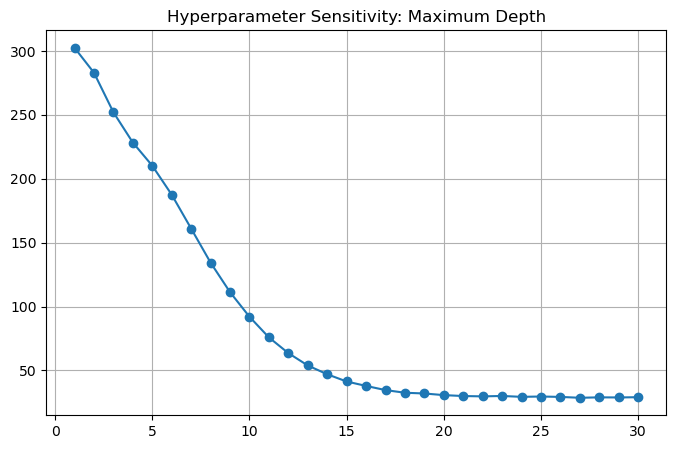

In [ ]:
X_train_, X_test_, y_train, y_test = train_test_split(X_,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=50,
                                                    stratify=groups)
groups_train = X_train_['category']
pipe.fit(X_train_)
X_train = pipe.transform(X_train_)
X_test = pipe.transform(X_test_)

depths = list(range(1,31,1))
results = []
for depth in depths:
    clf = RandomForestRegressor(max_depth=depth, 
                                max_features=np.float64(0.6496748671836832),
                                n_estimators=67,
                                random_state=0,
                                n_jobs = -1,
                                )
    scores = cross_val_score(clf,
                             X_train,
                             y_train,
                             cv = skfold.split(X_train, groups_train),
                             scoring = 'neg_mean_absolute_error',
                             n_jobs = -1,
                             )
    mean_mae = -np.mean(scores)
    std_mae = np.std(scores)
    results.append((depth, mean_mae, std_mae))

df_results = pd.DataFrame(results, columns=['model_depth', 'mean_mae', 'std_mae'])


<Figure size 800x500 with 0 Axes>

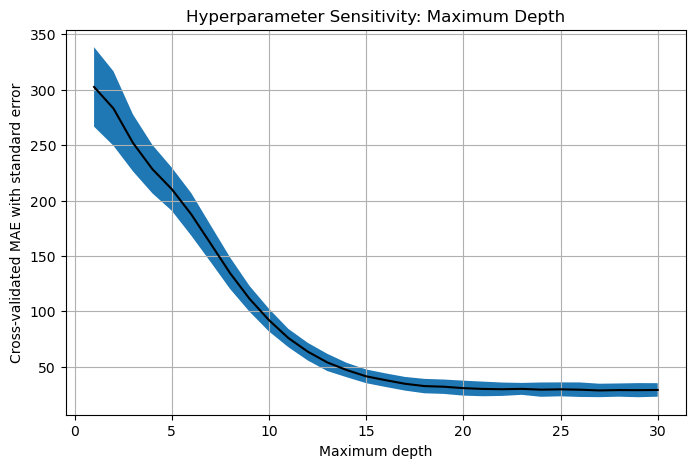

In [ ]:
plt.figure(figsize=(8, 5))
plt.figure(figsize=(8, 5))
plt.plot(df_results['model_depth'],
         df_results['mean_mae'],
         color='k')
plt.fill_between(df_results['model_depth'], 
                 df_results['mean_mae']-df_results['std_mae'].abs(),
                 df_results['mean_mae']+df_results['std_mae'].abs(),
                 alpha=0.3)
plt.xlabel('Maximum depth')
plt.ylabel('Cross-validated MAE with standard error')
plt.title('Hyperparameter Sensitivity: Maximum Depth')
plt.grid(True)
plt.show()

In [123]:
df_results[df_results['model_depth']>=15]

,model_depth,mean_mae,std_mae
14,15,41.389559,-6.176000
15,16,37.919579,-6.132836
16,17,34.666450,-6.169731
17,18,32.587385,-6.504896
18,19,32.004557,-6.483005
19,20,30.731422,-6.754563
20,21,30.014739,-6.598936
21,22,29.745884,-6.035886
22,23,30.063389,-5.375929
23,24,29.376175,-6.459215


In [ ]:
X_train_, X_test_, y_train, y_test = train_test_split(X_,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=50,
                                                    stratify=groups)
groups_train = X_train_['category']
pipe.fit(X_train_)
X_train = pipe.transform(X_train_)
X_test = pipe.transform(X_test_)

estimators = list(range(10,101,5))
results = []/100
for estimator in estimators:
    clf = RandomForestRegressor(max_depth = 22, 
                                max_features = results,
                                n_estimators = 67, 
                                random_state = 0,
                                n_jobs = -1)
    scores = cross_val_score(clf,
                             X_train,
                             y_train,
                             cv = skfold.split(X_train, groups_train),
                             scoring = 'neg_mean_absolute_error',
                             n_jobs=-1
                             )
    mean_mae = -np.mean(scores)
    std_mae = np.std(scores)
    results.append((estimator, mean_mae, std_mae))

df_results2 = pd.DataFrame(results, columns=['n_estimators', 'mean_mae', 'std_mae'])


<Figure size 800x500 with 0 Axes>

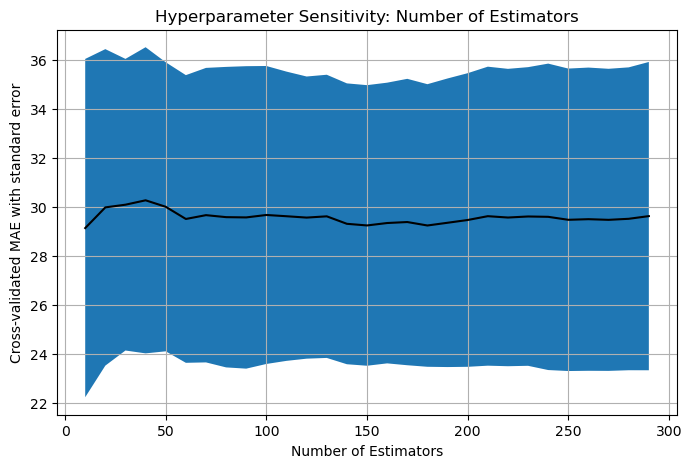

In [ ]:
plt.figure(figsize=(8, 5))
plt.figure(figsize=(8, 5))
plt.plot(df_results2['n_estimators'],
         df_results2['mean_mae'],
         color='k')
plt.fill_between(df_results2['n_estimators'], 
                 df_results2['mean_mae']-df_results2['std_mae'].abs(),
                 df_results2['mean_mae']+df_results2['std_mae'].abs(),
                 alpha=0.3)
plt.xlabel('Number of Estimators')
plt.ylabel('Cross-validated MAE with standard error')
plt.title('Hyperparameter Sensitivity: Number of Estimators')
plt.grid(True)
plt.show()

In [ ]:
X_train_, X_test_, y_train, y_test = train_test_split(X_,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=50,
                                                    stratify=groups)
groups_train = X_train_['category']
pipe.fit(X_train_)
X_train = pipe.transform(X_train_)
X_test = pipe.transform(X_test_)

features = list(range(1,31,1))
results = []
for feature in features:
    clf = RandomForestRegressor(max_depth=22, 
                                max_features=feature,
                                n_estimators=135,
                                random_state=0,
                                n_jobs = -1,
                                )
    scores = cross_val_score(clf,
                             X_train,
                             y_train,
                             cv = skfold.split(X_train, groups_train),
                             scoring = 'neg_mean_absolute_error',
                             n_jobs = -1,
                             )
    mean_mae = -np.mean(scores)
    std_mae = np.std(scores)
    results.append((feature, mean_mae, std_mae))

df_results3 = pd.DataFrame(results, columns=['model_features', 'mean_mae', 'std_mae'])


<Figure size 800x500 with 0 Axes>

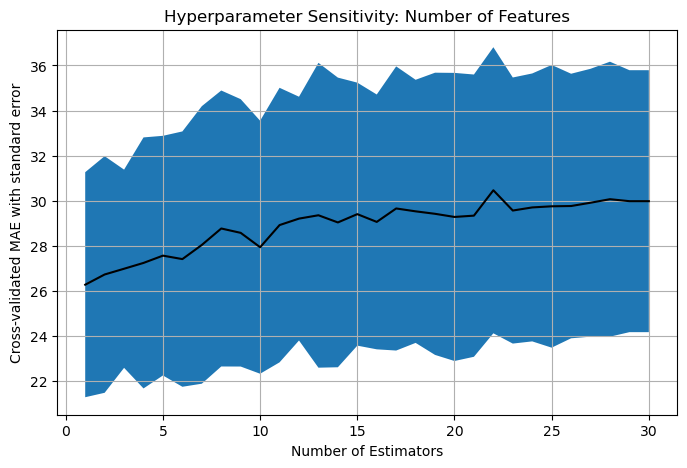

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(df_results3['model_features'],
         df_results3['mean_mae'],
         color='k')
plt.fill_between(df_results3['model_features'], 
                 df_results3['mean_mae']-df_results3['std_mae'].abs(),
                 df_results3['mean_mae']+df_results3['std_mae'].abs(),
                 alpha=0.3)
plt.xlabel('Number of Estimators')
plt.ylabel('Cross-validated MAE with standard error')
plt.title('Hyperparameter Sensitivity: Number of Features')
plt.grid(True)
plt.show()

In [130]:
X_train_, X_test_, y_train, y_test = train_test_split(X_,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=50,
                                                    stratify=groups)
groups_train = X_train_['category']
pipe.fit(X_train_)
X_train = pipe.transform(X_train_)
X_test = pipe.transform(X_test_)

features = list(range(1,21,1))
depths = list(range(1,31,1))

results = []
for feature in features:
    for depth in depths:
        clf = RandomForestRegressor(max_depth=depth, 
                                    max_features=feature,
                                    n_estimators=135,
                                    random_state=0,
                                    n_jobs = -1,
                                    )
        scores = cross_val_score(clf,
                                X_train,
                                y_train,
                                cv = skfold.split(X_train, groups_train),
                                scoring = 'neg_mean_absolute_error',
                                n_jobs = -1,
                                )
        mean_mae = -np.mean(scores)
        std_mae = np.std(scores)
        results.append((feature, depth, mean_mae, std_mae))

df_results4 = pd.DataFrame(results, 
                           columns=['model_features', 'model_depth', 'mean_mae', 'std_mae'])


In [ ]:
# Save the results for later use as the analysis takes an hour to run
df_results4.to_csv('df_results4.csv')

In [137]:
Z_grid = df_results4.pivot_table(index='model_depth', columns='model_features', values='mean_mae').sort_index(ascending=True)
x = Z_grid.columns.values
y = Z_grid.index.values
z = Z_grid.values

fig = go.Figure(data=[go.Surface(z=z, x=x, y=y)])
fig.update_layout(title=dict(text='Hyperparameter Sensitivity Analysis'), 
                #   autosize=True, 
                  width=600, 
                  height=400,
                  margin=dict(l=20, r=20, b=50, t=50),
                  scene=dict(
                      xaxis_title = 'Features',
                      yaxis_title = 'Depth',
                      zaxis_title = 'Mean MAE'
                  )
                  )
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [145]:
new_best_model_rfr = RandomForestRegressor(max_depth=22, 
                                    max_features=5,
                                    n_estimators=135,
                                    random_state=0,
                                    n_jobs = -1,
                                    )
new_best_model_rfr.fit(X_train, y_train)
new_y_pred = new_best_model_rfr.predict(X_test)
print(r2_score(y_test, new_y_pred))
print(mean_absolute_error(y_test, new_y_pred))

0.9954901203700031
23.01533590885387


/var/folders/15/mh2mgzhn1191h4zq_5d03wfc0000gn/T/ipykernel_45517/120606719.py:9: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.



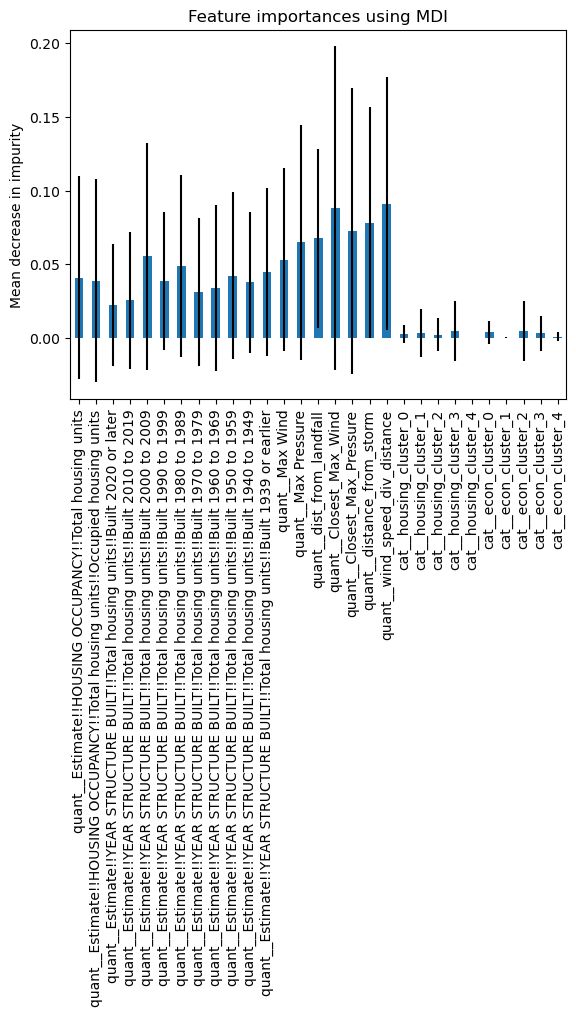

In [146]:
importances = new_best_model_rfr.feature_importances_
feature_names = [i for i in X__.columns]
std = np.std([tree.feature_importances_ for tree in new_best_model_rfr.estimators_], axis=0)
forest_importances = pd.Series(importances, index=feature_names)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

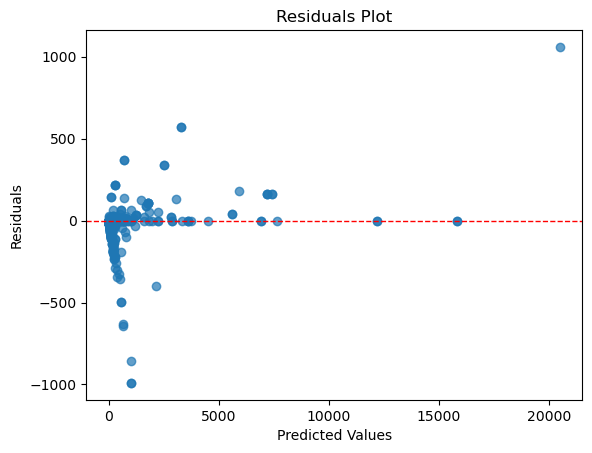

In [147]:
y_pred = new_best_model_rfr.predict(X_test)
residuals = y_test - y_pred

# Plot residuals
plt.scatter(y_pred, residuals, alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--', linewidth=1)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals Plot")
plt.show()

Feature Importance Ranking:
 Index(['quant__wind_speed_div_distance', 'quant__Closest_Max_Wind',
       'quant__distance_from_storm', 'quant__Closest_Max_Pressure',
       'quant__dist_from_landfall', 'quant__Max Pressure',
       'quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2000 to 2009',
       'quant__Max Wind',
       'quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1980 to 1989',
       'quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1939 or earlier',
       'quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1950 to 1959',
       'quant__Estimate!!HOUSING OCCUPANCY!!Total housing units',
       'quant__Estimate!!HOUSING OCCUPANCY!!Total housing units!!Occupied housing units',
       'quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1990 to 1999',
       'quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1940 to 1949',
       'quant__Estimate!!YEAR STRUCTURE BUILT!!Total hous

/var/folders/15/mh2mgzhn1191h4zq_5d03wfc0000gn/T/ipykernel_45517/1642923347.py:19: MatplotlibDeprecationWarning:

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.

/var/folders/15/mh2mgzhn1191h4zq_5d03wfc0000gn/T/ipykernel_45517/1642923347.py:25: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.



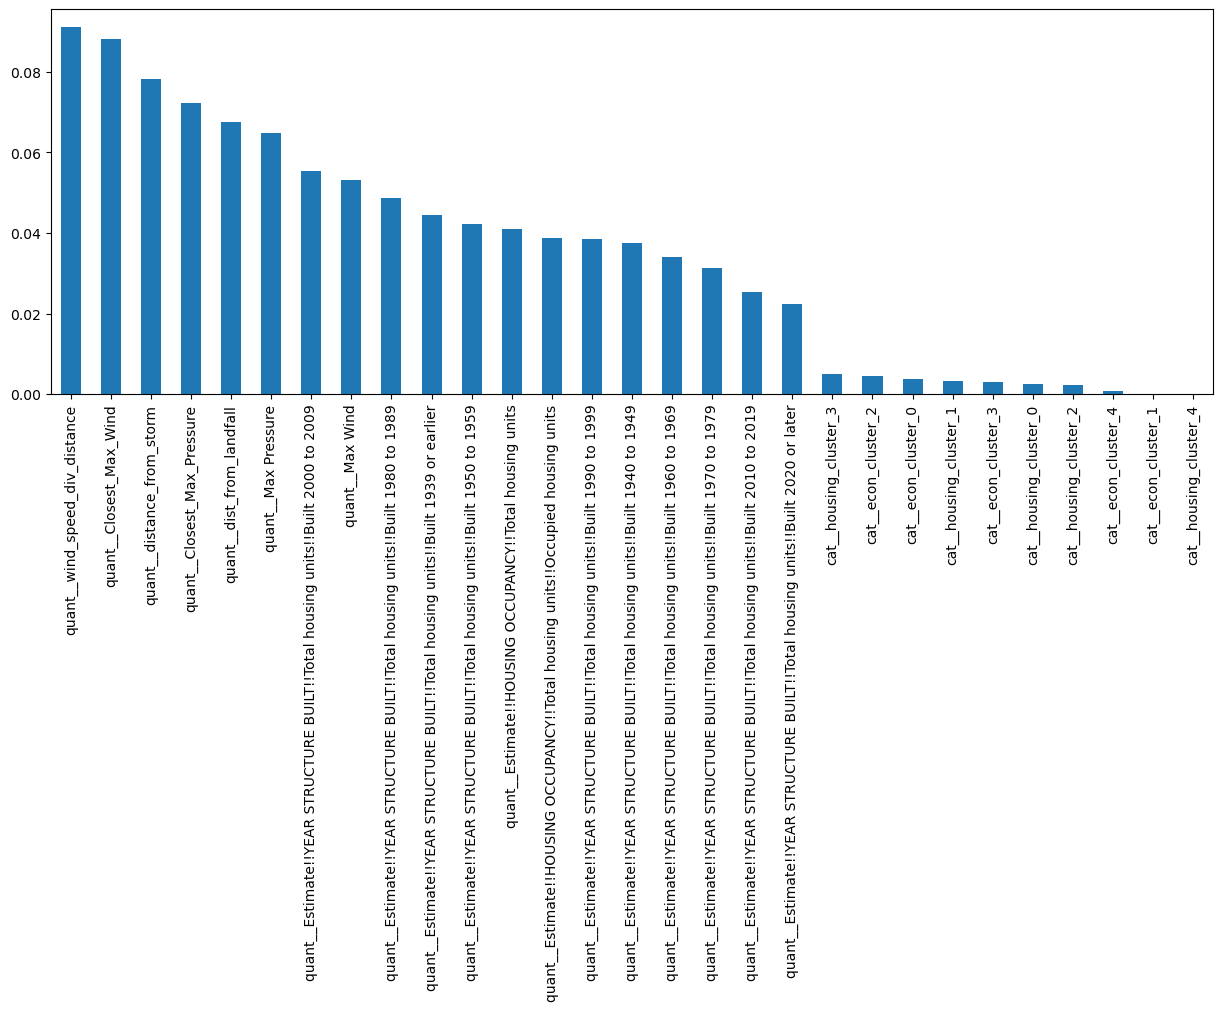

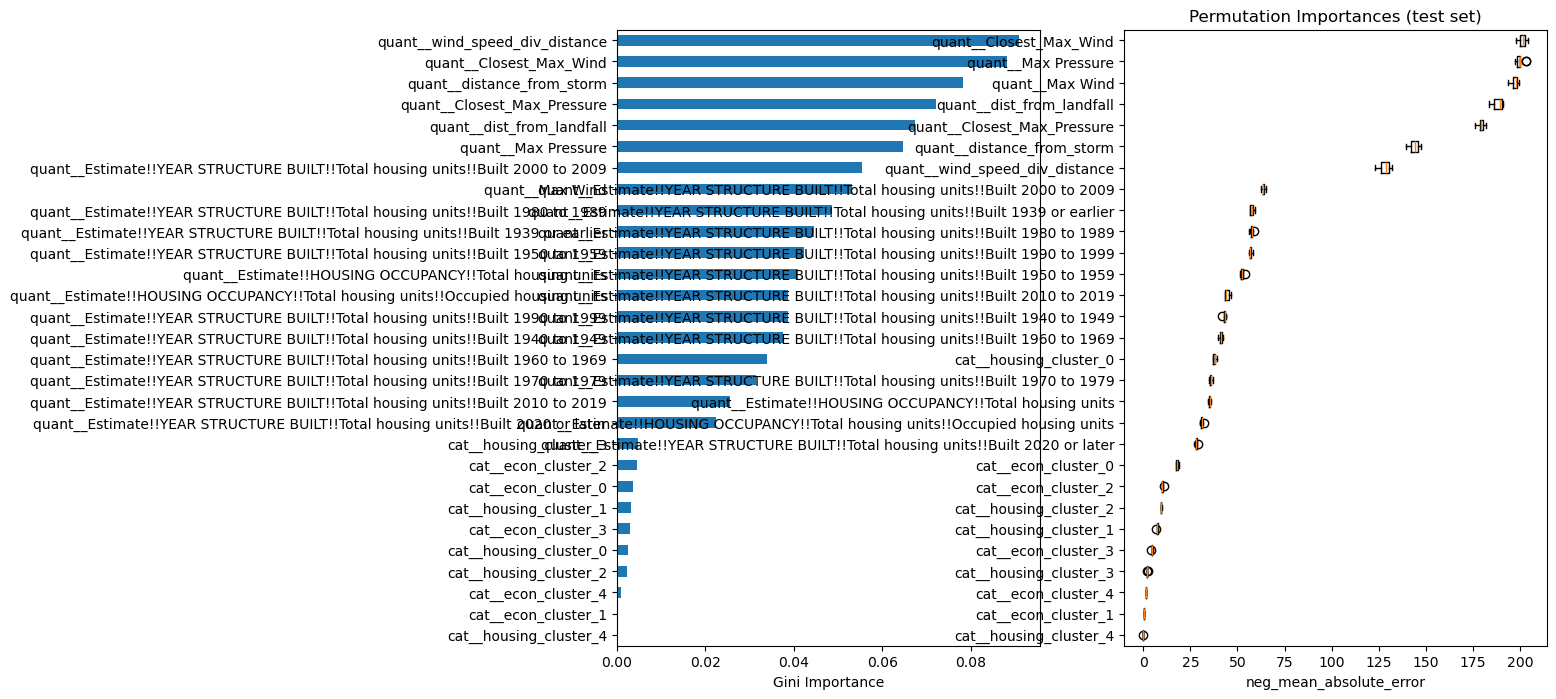

/var/folders/15/mh2mgzhn1191h4zq_5d03wfc0000gn/T/ipykernel_45517/1642923347.py:59: UserWarning:

Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations

/var/folders/15/mh2mgzhn1191h4zq_5d03wfc0000gn/T/ipykernel_45517/1642923347.py:19: MatplotlibDeprecationWarning:

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.

/var/folders/15/mh2mgzhn1191h4zq_5d03wfc0000gn/T/ipykernel_45517/1642923347.py:25: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.



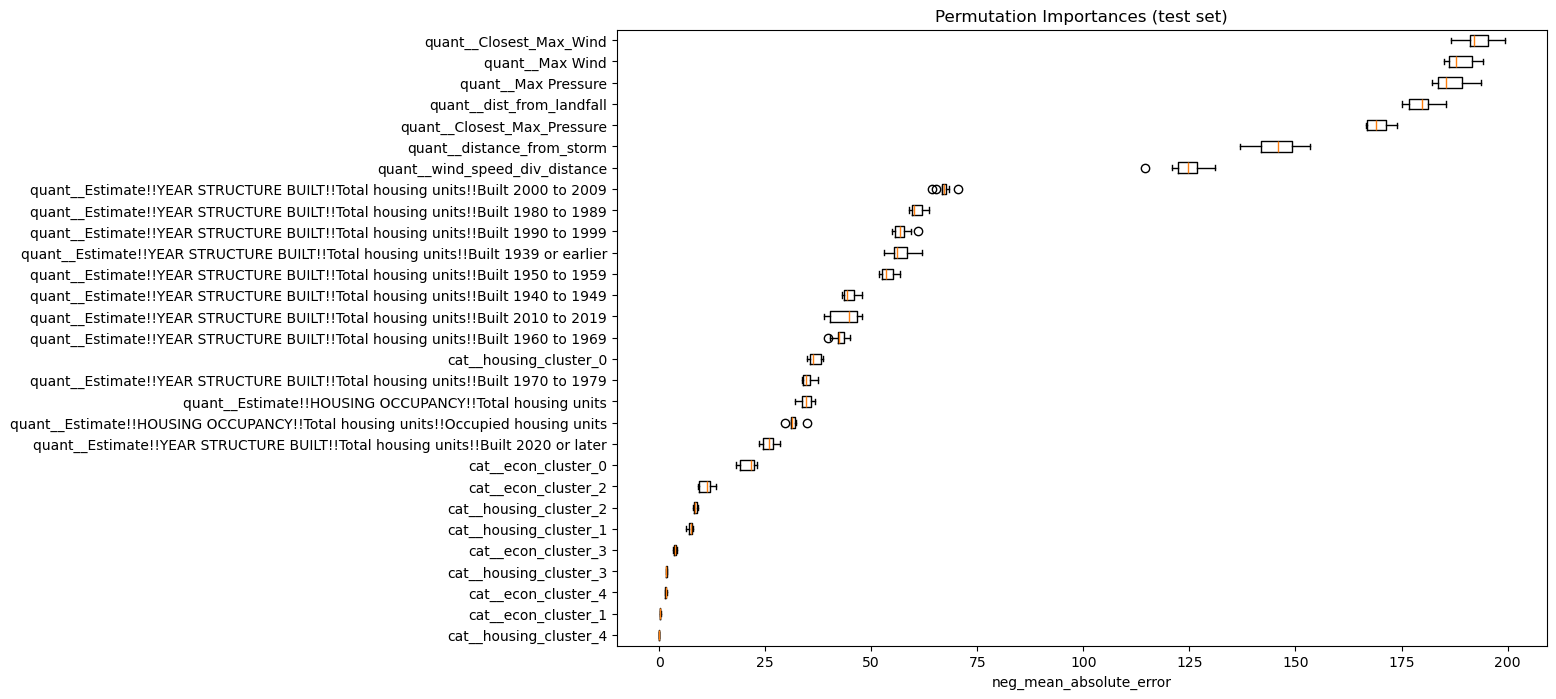

In [148]:
display_feature_importance(new_best_model_rfr,
                           X_train,
                           X_test,
                           y_train,
                           y_test)

In [186]:
states = list(range(1,11))
learning_curves = []
ratios = np.linspace(20, 95, 16)/100

for j in ratios:
    states = list(range(1,11))
    score_list = []
    for i in states:
        X_train_, X_test_, y_train, y_test = train_test_split(X_,
                                                              y,
                                                              train_size=j,
                                                              random_state=i,
                                                              stratify=groups,
                                                              )
        pipe.fit(X_train_)
        X_train = pipe.transform(X_train_)
        X_test = pipe.transform(X_test_)
        new_best_model_rfr.fit(X_train, y_train)
        rf_preds = new_best_model_rfr.predict(X_test)
        rf_score = mean_absolute_error(y_test, rf_preds)
        score_list.append(rf_score)
        learning_curves.append((j, i, rf_score))
    print(f'Train size: {j}')    
    print(f'Mean MAE: {np.mean(score_list)}')
    print(f'STD MAE: {np.std(score_list)}')

states = list(range(1,11))
score_list = []
for i in states:
    X_train_, X_test_, y_train, y_test = train_test_split(X_,
                                                          y,
                                                          test_size=0.2,
                                                          random_state=i,
                                                          stratify=groups,
                                                          )
    pipe.fit(X_train_)
    X_train = pipe.transform(X_train_)
    X_test = pipe.transform(X_test_)
    new_best_model_rfr.fit(X_train, y_train)
    rf_preds = new_best_model_rfr.predict(X_test)
    rf_score = mean_absolute_error(y_test, rf_preds)
    score_list.append(rf_score)
print(f'Random state test')
print(f'Mean MAE: {np.mean(score_list)}')
print(f'STD MAE: {np.std(score_list)}')

Train size: 0.2
Mean MAE: 159.64086195684365
STD MAE: 7.757058464947944
Train size: 0.25
Mean MAE: 135.31778593210302
STD MAE: 9.950296249436066
Train size: 0.3
Mean MAE: 112.38761627295621
STD MAE: 9.341362441675455
Train size: 0.35
Mean MAE: 94.16573320732132
STD MAE: 11.598526619165913
Train size: 0.4
Mean MAE: 80.43222530796669
STD MAE: 11.854078875144815
Train size: 0.45
Mean MAE: 69.41445710944615
STD MAE: 11.325761898112772
Train size: 0.5
Mean MAE: 57.899193139731175
STD MAE: 6.898174205033931
Train size: 0.55
Mean MAE: 47.99286418109247
STD MAE: 6.980896183325804
Train size: 0.6
Mean MAE: 39.50521938475813
STD MAE: 4.527498639218745
Train size: 0.65
Mean MAE: 33.853640983427184
STD MAE: 4.048432991905793
Train size: 0.7
Mean MAE: 27.47310670534681
STD MAE: 3.062502539901484
Train size: 0.75
Mean MAE: 23.47116924057396
STD MAE: 2.9955714412139525
Train size: 0.8
Mean MAE: 19.430092184613493
STD MAE: 2.994040226714659
Train size: 0.85
Mean MAE: 17.55589580652522
STD MAE: 3.36110

In [188]:
df_learning = pd.DataFrame(learning_curves,
    columns=['train_size', 'random_state', 'MAE'],
    )
df_learning

,train_size,random_state,MAE
0,0.20,1,154.208190
1,0.20,2,159.057584
2,0.20,3,151.562269
3,0.20,4,163.970673
4,0.20,5,149.305529
...,...,...,...
155,0.95,6,10.186367
156,0.95,7,12.362461
157,0.95,8,23.768064
158,0.95,9,10.668908


In [191]:
df_learning_curves = df_learning.groupby('train_size').agg(
    mean_mae = ('MAE', 'mean'),
    std_mae = ('MAE', 'std')
).reset_index()

df_learning_curves

,train_size,mean_mae,std_mae
0,0.20,159.640862,8.176658
1,0.25,135.317786,10.488533
2,0.30,112.387616,9.846661
3,0.35,94.165733,12.225921
4,0.40,80.432225,12.495296
5,0.45,69.414457,11.938401
6,0.50,57.899193,7.271314
7,0.55,47.992864,7.358511
8,0.60,39.505219,4.772403
9,0.65,33.853641,4.267423


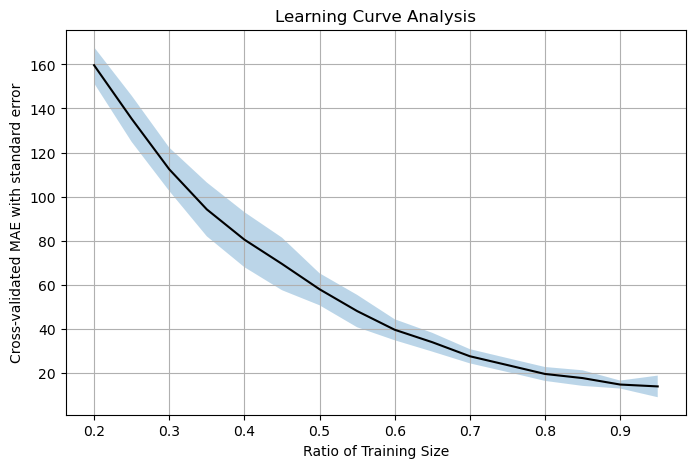

In [192]:
plt.figure(figsize=(8, 5))
plt.plot(df_learning_curves['train_size'],
         df_learning_curves['mean_mae'],
         color='k')
plt.fill_between(df_learning_curves['train_size'], 
                 df_learning_curves['mean_mae']-df_learning_curves['std_mae'].abs(),
                 df_learning_curves['mean_mae']+df_learning_curves['std_mae'].abs(),
                 alpha=0.3)
plt.xlabel('Ratio of Training Size')
plt.ylabel('Cross-validated MAE with standard error')
plt.title('Learning Curve Analysis')
plt.grid(True)
plt.show()

In [155]:
drop_list = [
    [
        'Estimate!!HOUSING OCCUPANCY!!Total housing units',
        'Estimate!!HOUSING OCCUPANCY!!Total housing units!!Occupied housing units',
    ],
    [
        'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2020 or later',
        'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2010 to 2019',
        'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2000 to 2009',
        'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1990 to 1999',
        'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1980 to 1989',
        'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1970 to 1979',
        'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1960 to 1969',
        'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1950 to 1959',
        'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1940 to 1949',
        'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1939 or earlier',
    ],
    [
        'Max Wind',
        'Max Pressure',
        'dist_from_landfall',
    ],
    [
        'category'
    ],
]
for item_list in drop_list:
    _ = X_.drop(labels=item_list,
        axis=1,
        )

    _quants = quants.copy()
    _categories = categories.copy()
    for item in item_list:
        try:
            _quants.remove(item)
        except:
            _categories.remove(item)

    preprocessor = ColumnTransformer(
        transformers=[
            ('quant', Normalizer(), _quants),
            ('cat', OneHotEncoder(sparse_output=False).set_output(transform='pandas'), _categories)
        ]
    ).set_output(transform='pandas')
    pipe1 = Pipeline(steps=
                    [('preprocessor', preprocessor),
                    ])
    states = list(range(1,11))
    score_list = []
    for i in states:
        X_train_, X_test_, y_train, y_test = train_test_split(_,
                                                              y,
                                                              test_size=0.2,
                                                              random_state=i,
                                                              stratify=groups)
        pipe1.fit(X_train_)
        X_train = pipe1.transform(X_train_)
        X_test = pipe1.transform(X_test_)
        new_best_model_rfr.fit(X_train, y_train)
        rf_preds = new_best_model_rfr.predict(X_test)
        rf_score = mean_absolute_error(y_test, rf_preds)
        score_list.append(rf_score)
    print(item_list)
    print(score_list)
    print(-np.mean(score_list))
    print(np.std(score_list))



['Estimate!!HOUSING OCCUPANCY!!Total housing units', 'Estimate!!HOUSING OCCUPANCY!!Total housing units!!Occupied housing units']
[16.44220002218925, 24.923232811519345, 14.398737405689939, 22.494990323663178, 18.46682817196223, 21.12984477370345, 19.062964596609675, 17.328109724996583, 16.901321411189063, 19.088665943419116]
-19.023689518494184
2.95025416898947
['Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2020 or later', 'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2010 to 2019', 'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2000 to 2009', 'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1990 to 1999', 'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1980 to 1989', 'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1970 to 1979', 'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1960 to 1969', 'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1950 to 1959', 'Estimate!!YEAR STRUCTURE BUILT!!T

In [159]:
new_best_model_rfr.fit(X_train, y_train)

df_compare = X_test.copy()
df_compare['target'] = y_test
df_compare['prediction'] = new_best_model_rfr.predict(X_test)
df_compare['delta'] = df_compare['prediction'] - df_compare['target']
df_compare = df_compare.assign(entry=range(1, len(df_compare)+1))
df_compare

,quant__Estimate!!HOUSING OCCUPANCY!!Total housing units,quant__Estimate!!HOUSING OCCUPANCY!!Total housing units!!Occupied housing units,quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2020 or later,quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2010 to 2019,quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2000 to 2009,quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1990 to 1999,quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1980 to 1989,quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1970 to 1979,quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1960 to 1969,quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1950 to 1959,...,cat__housing_cluster_4,cat__econ_cluster_0,cat__econ_cluster_1,cat__econ_cluster_2,cat__econ_cluster_3,cat__econ_cluster_4,target,prediction,delta,entry
3575,0.701502,0.627114,0.009207,0.052320,0.087249,0.162076,0.141470,0.035075,0.083888,0.027768,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,14.547261,14.547261,1
652,0.734993,0.619040,0.000000,0.000000,0.071594,0.135181,0.133194,0.113265,0.074049,0.062126,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.916210,3.916210,2
3018,0.720857,0.645764,0.000000,0.000000,0.059122,0.122679,0.117986,0.106600,0.090994,0.071318,...,0.0,1.0,0.0,0.0,0.0,0.0,22.0,72.213299,50.213299,3
5136,0.731721,0.603698,0.000000,0.010213,0.117098,0.145679,0.150984,0.151776,0.056372,0.054946,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2.904753,1.904753,4
3645,0.706670,0.631512,0.010892,0.060187,0.168197,0.125312,0.215942,0.081030,0.023896,0.012715,...,0.0,1.0,0.0,0.0,0.0,0.0,593.0,589.688889,-3.311111,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
646,0.788052,0.528168,0.000000,0.000000,0.053010,0.112319,0.138597,0.176737,0.140527,0.072817,...,0.0,0.0,0.0,1.0,0.0,0.0,14.0,14.229289,0.229289,1294
4237,0.747694,0.528555,0.000000,0.011612,0.070237,0.180181,0.121182,0.155832,0.115750,0.031091,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,17.666869,17.666869,1295
3474,0.752283,0.580615,0.025295,0.079014,0.165305,0.114220,0.179699,0.122846,0.043832,0.017660,...,0.0,1.0,0.0,0.0,0.0,0.0,620.0,620.000000,0.000000,1296
136,0.764371,0.550884,0.000000,0.053970,0.146721,0.183276,0.135537,0.167919,0.030379,0.020976,...,0.0,1.0,0.0,0.0,0.0,0.0,190.0,161.591610,-28.408390,1297


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=6a6374cd-5e77-49b2-b1d3-d73b9b2f23ac' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>

(73, 39)


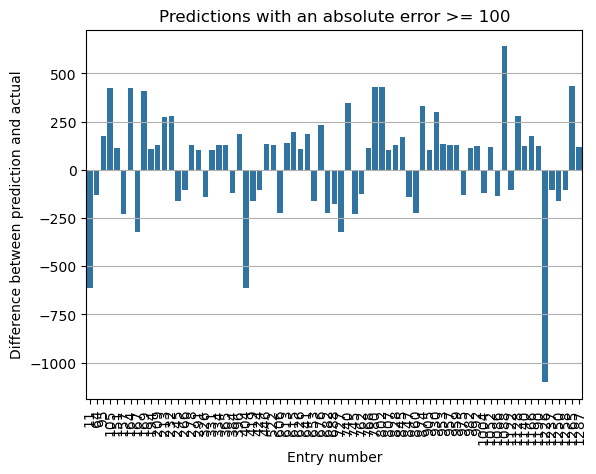

In [180]:
print(df_compare[df_compare['delta'].abs()>100].shape)
sns.barplot(data = df_compare[df_compare['delta'].abs()>100],
            x = 'entry',
            y='delta'
            )
plt.title('Predictions with an absolute error >= 100')
plt.ylabel('Difference between prediction and actual')
plt.xlabel('Entry number')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.show()

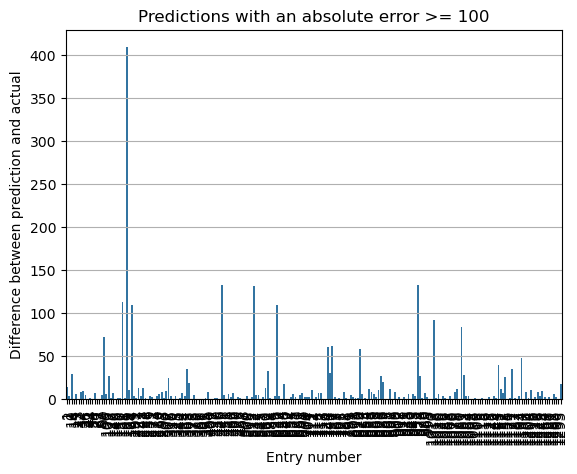

In [181]:
sns.barplot(data = df_compare[df_compare['target']==0],
            x = 'entry',
            y='delta'
            )
plt.title('Predictions with an absolute error >= 100')
plt.ylabel('Difference between prediction and actual')
plt.xlabel('Entry number')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.show()

In [177]:
df_largest_deltas = df_compare[df_compare['delta'].abs()>500]
df_largest_deltas

,quant__Estimate!!HOUSING OCCUPANCY!!Total housing units,quant__Estimate!!HOUSING OCCUPANCY!!Total housing units!!Occupied housing units,quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2020 or later,quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2010 to 2019,quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2000 to 2009,quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1990 to 1999,quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1980 to 1989,quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1970 to 1979,quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1960 to 1969,quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1950 to 1959,...,cat__housing_cluster_4,cat__econ_cluster_0,cat__econ_cluster_1,cat__econ_cluster_2,cat__econ_cluster_3,cat__econ_cluster_4,target,prediction,delta,entry
127,0.731563,0.627737,0.000000,0.059645,0.111884,0.097032,0.100093,0.131832,0.092233,0.084076,...,0.0,1.0,0.0,0.0,0.0,0.0,3844.0,3230.996296,-613.003704,11
128,0.731563,0.627737,0.000000,0.059645,0.111884,0.097032,0.100093,0.131832,0.092233,0.084076,...,0.0,1.0,0.0,0.0,0.0,0.0,3844.0,3230.996296,-613.003704,404
6145,0.735714,0.621571,0.001062,0.040002,0.074023,0.071078,0.105906,0.149004,0.118300,0.098491,...,0.0,0.0,0.0,1.0,0.0,0.0,125.0,765.106578,640.106578,1088
100,0.713201,0.646752,0.000000,0.058186,0.139729,0.091318,0.115580,0.139228,0.072157,0.054184,...,0.0,1.0,0.0,0.0,0.0,0.0,21555.0,20452.696296,-1102.303704,1226


In [ ]:
X_train.to_csv('xtrain.csv')
X_test.to_csv('xtest.csv')
y_train.to_csv('ytrain.csv')
y_test.to_csv('ytest.csv')
